In [4]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps 

In [5]:
def show_img(img0,title=None):
    img=img0.numpy()
    plt.axis("off")
    if title:
        plt.text(75, 8, text, style='italic',fontweight='bold',bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()
                                                                     
def plot_loss(iteration,loss):
    plt.plot(iteration,loss)        
    plt.show()

# 定义dataset和dataloader

In [6]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset=imageFolderDataset
        self.transform=transform
        self.should_invert=should_invert
        
    def __getitem__(self,index):  #获取图片1、图片2、标签
        img1_folder=random.choice(self.imageFolderDataset.imgs)
        genuine_imposter_ratio=random.randint(0,1)  #随机0或1，真匹配和假匹配概率一样
        if genuine_imposter_ratio:
            while True:
                img2_folder=random.choice(self.imageFolderDataset.imgs)
                if img1_folder[1]==img2_folder[1]:
                    break
        else:
            while True:
                img2_folder=random.choice(self.imageFolderDataset.imgs)
                if img1_folder[1]!=img2_folder[1]:
                    break
                    
        #装换成灰度图            
        img1=Image.open(img1_folder[0])
        img2=Image.open(img2_folder[0])
        img1=img1.convert('L')
        img2=img2.convert('L')
        
        if self.should_invert:
            img1=Image.ImageOps.invert(img1)
            img2=Image.ImageOps.invert(img2) 
            
        if self.transform is not None:
            img1=self.transform(img1)
            img2=self.transform(img2)  
        #                                    同类为0，不同类为1
        return img1,img2,torch.from_numpy(np.array([int(img1_folder[1]!=img2_folder[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
#定义训练集地址
train_dir='D:/数据库/palmdata/iitd'
batch_size=32

folder_dataset = torchvision.datasets.ImageFolder(root=train_dir)

transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])

siamese_dataset=SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform=transform,should_invert=False)

train_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=batch_size)

# 可视化几个训练图片

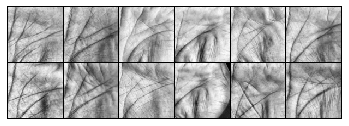

[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [7]:
visual_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=6)
x1,x2,y=next(iter(visual_dataloader))
concatenated = torch.cat((x1,x2),0) 
show_img(torchvision.utils.make_grid(concatenated, nrow=6))
print(y.numpy())

# 构建模型

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn=nn.Sequential(
            nn.ReflectionPad2d(1),   #padding
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )
        self.fc=nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )
    def output(self,x):
        output=self.cnn(x)
        output=output.view(output.size()[0],-1)
        output=self.fc(output)
        return output
    def forward(self,x1,x2):
        output1=self.output(x1)
        output2=self.output(x2) 
        return output1,output2
    
#自定义损失函数
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

SiameseNetwork(
  (cnn): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)


# 训练模型

Epoch number: 0 , Current loss: 1.4399

Epoch number: 1 , Current loss: 0.7631

Epoch number: 2 , Current loss: 0.9441

Epoch number: 3 , Current loss: 0.5396

Epoch number: 4 , Current loss: 0.1120

Epoch number: 5 , Current loss: 0.4168

Epoch number: 6 , Current loss: 0.3308

Epoch number: 7 , Current loss: 0.4563

Epoch number: 8 , Current loss: 0.0611

Epoch number: 9 , Current loss: 0.0876

Epoch number: 10 , Current loss: 0.1379

Epoch number: 11 , Current loss: 0.1249

Epoch number: 12 , Current loss: 0.1273

Epoch number: 13 , Current loss: 0.1368

Epoch number: 14 , Current loss: 0.1576

Epoch number: 15 , Current loss: 0.1577

Epoch number: 16 , Current loss: 0.0479

Epoch number: 17 , Current loss: 0.1001

Epoch number: 18 , Current loss: 0.1082

Epoch number: 19 , Current loss: 0.0343

Epoch number: 20 , Current loss: 0.1438

Epoch number: 21 , Current loss: 0.0827

Epoch number: 22 , Current loss: 0.0716

Epoch number: 23 , Current loss: 0.0712

Epoch number: 24 , Current

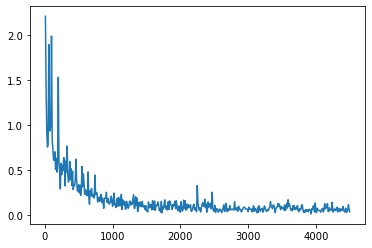

In [6]:
net = SiameseNetwork().cuda() #定义模型且移至GPU
criterion = ContrastiveLoss() #定义损失函数
optimizer = optim.Adam(net.parameters(), lr = 0.0005) #定义优化器

epochs=50
counter = []
loss_history = [] 
iteration_number = 0


#开始训练
for epoch in range(0, epochs):
    for i, data in enumerate(train_dataloader, 0):
        img1, img2 , y = data
        #img0维度为torch.Size([32, 1, 100, 100])，32是batch，label为torch.Size([32, 1])
        img1, img2 , y = img1.cuda(), img2.cuda(), y.cuda() #数据移至GPU
        optimizer.zero_grad()
        output1,output2 = net(img1, img2)
        loss_contrastive = criterion(output1, output2, y)
        loss_contrastive.backward()
        optimizer.step()
        if i % 10 == 0 :
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    print("Epoch number: {} , Current loss: {:.4f}\n".format(epoch,loss_contrastive.item()))

plot_loss(counter, loss_history)

# 测试模型

In [7]:
loss_=[]
for i, data in enumerate(train_dataloader, 0):
    img1, img2 , y = data
    #img0维度为torch.Size([32, 1, 100, 100])，32是batch，label为torch.Size([32, 1])
    img1, img2 , y = img1.cuda(), img2.cuda(), y.cuda() #数据移至GPU
    output11, output22=net(img1,img2)
    loss_contrastive = criterion(output11, output22, y)
    if i % 10 == 0 :
            loss_.append(loss_contrastive.item())
print(sum(loss_)/50)

0.01446013070642948


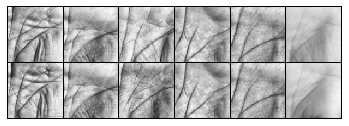

true:
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]
pre
tensor(0, device='cuda:0', dtype=torch.uint8)
tensor(0, device='cuda:0', dtype=torch.uint8)
tensor(1, device='cuda:0', dtype=torch.uint8)
tensor(0, device='cuda:0', dtype=torch.uint8)
tensor(0, device='cuda:0', dtype=torch.uint8)
tensor(0, device='cuda:0', dtype=torch.uint8)


In [8]:
test_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=6)
x1,x2,y=next(iter(test_dataloader))
concatenated = torch.cat((x1,x2),0) 
show_img(torchvision.utils.make_grid(concatenated, nrow=6))
print('true:')
print(y.numpy())
      
print('pre')
x1,x2,y=x1.cuda(),x2.cuda(),y.cuda()
out1,out2 = net.forward(x1,x2)
oushi=torch.dist(out1, out2, p=2)   #求欧式
oushi=torch.sqrt(((out1-out2)**2))  #这句跟上面等效，也是求欧式？
for i in range(6):
    d=sum(oushi[i])/5
    print(d>=1)